# Notebook 5: Inferring underlying parameters from data

In notebook 4 we investigated the connection between the underlying transmission process model and observable events. 
However, we used posterior mean estimates for the unknown parameters of the model. In this notebook, we look at how the posterior distributions for the parameters were generated. In this notebook we cover:

* Relative detection rate.
* The `CoVAreaModel` struct, this is the object that we use to contain available data for the county, and the log-likelihood model.
* Defining the parameters of the model using the `TransformVariables` package.
* Finding a good initialisation of the inference method.
* Running the inference method (Hamiltonian MCMC), and adding the results to the `CoVAreaModel` struct.

First, we load the data we need for the inference problem.

In [34]:
cd(joinpath(homedir(),"GitHub/KenyaSerology/")) #Sets the working directory to the /KenyaSerology directory
push!(LOAD_PATH, joinpath(homedir(),"GitHub/KenyaSerology/src")) #Adds the source code directory for KenyaSerology to the LOAD_PATH global variable

using JLD2,Plots,Dates
using Distributions,TransformVariables,Parameters #These packages define some useful methods

import KenyaSerology

#Load data
@load("data/projected_contact_data_10082020.jld2");
@load("data/case_data_by_area_21feb_to_6aug.jld2");
@load("data/serologydata_21feb_6aug.jld2");
@load("data/relative_testing_rate.jld2");

Each data file should be familiar from previous notebooks except `relative_testing_rate.jld2`. This file contains a linear fit to testing rate relative to the mean tests per day (2,482 tests per day which occured around 1st June). The extra testing rate seemed to apply mainly to Nairobi and surronding counties (Kiambu, Kajiado, Machakos). Therefore, in the underlying detection rate was assumed to be proportional to this increasing rate in those counties and flat in other counties. Samples from before 12th April are ignored in all counties (testing was extremely patchy before mid-April).

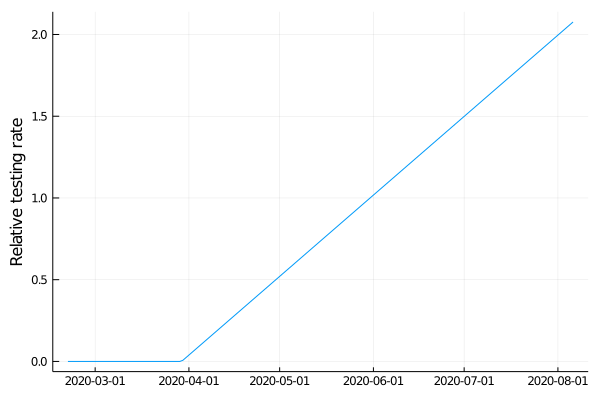

In [35]:
plot(relative_testing_rate_nairobi.date[relative_testing_rate_nairobi.date .<= Date(2020,8,6)],
    relative_testing_rate_nairobi.relative_testing_rate[relative_testing_rate_nairobi.date .<= Date(2020,8,6)],
    ylabel = "Relative testing rate",lab ="")

To run inference on a county we bundle all the necessary data, in addition to a choice of log-likelihood function and a choice of prior distributions into a `CoVAreaModel` type struct (defined in the `KenyaSerology` package). 

We use Nairobi as an example, and as in previous notebooks collect the relevant data and define an ODE problem for Nairobi.

In [36]:
#Define the transmission model (see notebook 4) --- We infer up to 6th August so no point solving past that point for inference
transmission_prob = KenyaSerology.make_odeproblemforinference(projected_contactrate_nairobi,#Method for defining the ODE problem underlying the inference
                                                                                        startdate = Date(2020,2,21),#Don't change from Feb 21st as start date!
                                                                                        enddate = Date(2020,8,6)) #Solve until the end of the inference period

#Convert the cases for Nairobi into a vector, each entry is number of PCR-pos swabs collected that day
#This is a 168-length vector (each day 21st Feb to 6th Aug)
cases = vec(case_data.cases[:,case_data.areas .== "NAIROBI"]);
#Convert the serology data into a matrix 168x2 for each day and positive/negative tests
sero = Matrix(sero_data.serodata[:,sero_data.areas .== "nairobi",:][:,1,:]);

To define the inference problem we need a log-likelihood function and log-prior function. Both of these functions which implement the priors and likelihood model described in the main paper are available from the `KenyaSerology` package.

In [37]:
log_priors = KenyaSerology.basic_prior_nairobi
log_likelihood = KenyaSerology.loglikelihood_contactratemodelBB_Peff

loglikelihood_contactratemodelBB_Peff (generic function with 1 method)

The `log_priors` function accepts a `NamedTuple` of parameter arguments and returns the log-density for prior at that point. To demonstrate we plot the log-prior density along a slice of fixed parameters, varying only R, which reflects our underlying belief that prior to data $R_0 \sim \Gamma(2,2.5/2)$, that is prior mean 2.5 but skewed towards lower values.

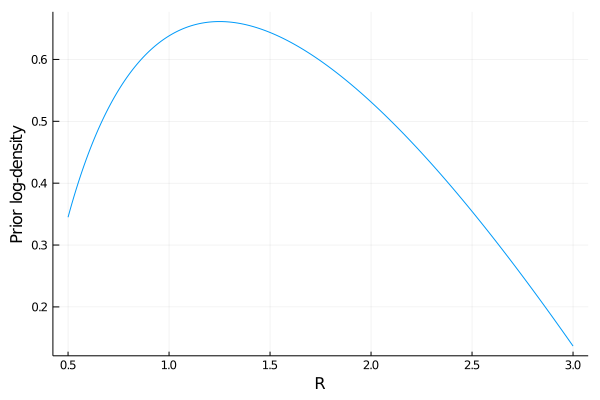

In [38]:
log_prior_density_R₀ = [log_priors((E₀=40,I₀=2.56,R = R₀,α=0.48,p_test=3.4e-4,P_eff = 0.77) ) for R₀ in 0.5:0.01:3 ]
plot(0.5:0.01:3,log_prior_density_R₀,ylabel = "Prior log-density",xlabel = "R",lab="")

The log-likelihood function has two arguments: a `NamedTuple` that reads in the parameters and `CoVAreaModel` struct which reads in the data. The `CoVAreaModel` type struct is defined in the `KenyaSerology` package. We construct one for Nairobi below.

In [49]:
#Construct the inference model using keyword arguments
nairobi_inference_model = KenyaSerology.CoVAreaModel(areaname = "Nairobi",
                                        PCR_cases = cases,#See above
                                        sero_cases = sero,#See above
                                        dates = case_data.dates,
                                        N = 4.3e6,
                                        relative_testing_rate = relative_testing_rate_nairobi.relative_testing_rate,
                                        contactrate_data = projected_contactrate_nairobi,
                                        prob = transmission_prob, #See above
                                        log_priors = log_priors,#See above
                                        log_likelihood = log_likelihood)

KenyaSerology.CoVAreaModel
  areaname: String "Nairobi"
  PCR_cases: Array{Int64}((168,)) [0, 0, 0, 0, 0, 0, 0, 2, 0, 0  …  585, 489, 578, 308, 112, 51, 188, 564, 370, 153]
  sero_cases: Array{Int64}((168, 2)) [0 0; 0 0; … ; 0 0; 0 0]
  dates: Array{Date}((168,))
  N: Float64 4.3e6
  σ: Float64 0.3225806451612903
  γ: Float64 0.4166666666666667
  contactrate_data: NamedTuple{(:contactrate, :date, :area),Tuple{Array{Float64,2},Array{Date,1},String}}
  relative_testing_rate: Array{Float64}((316,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
  prob: DiffEqBase.ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},DiffEqBase.ODEFunction{true,KenyaSerology.var"#f#20"{KenyaSerology.var"#getcontactrate#19"{Array{Float64,1}}},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Array{Symbol,1},Nothing},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTup

You should note that there are more fields in the `nairobi_inference_model` than used in constuction. This is because `KenyaSerology` has default values for a number of fields which were defined in the main paper (e.g. the default relative detection rate by serology is as shown in notebook 4 etc).

The log-likelihood + log-prior value for a choice of parameters given the data is a *callable* function of the `CoVAreaModel`. This means that we can use the `nairobi_inference_model` struct as a function. This automatically take the data, choice of prior, and choice of log-likelihood function into account. Below we plot the posterior density along a slice. This shows hows much the data moves our estimates away from the weak prior used.

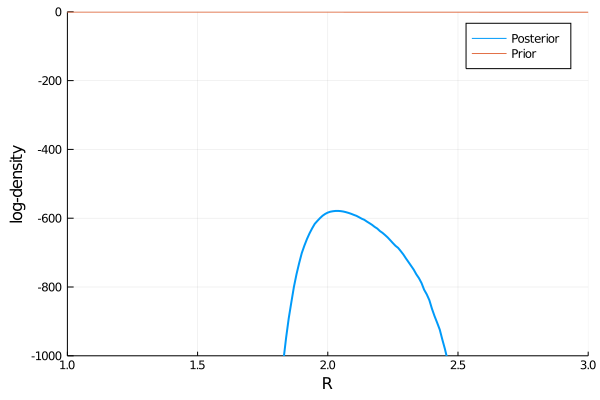

In [54]:
log_posterior_density_R₀ = [nairobi_inference_model((E₀=40,I₀=2.56,R = R₀,α=0.48,p_test=3.4e-4,P_eff = 0.77) ) for R₀ in 0.5:0.01:3 ]
plot(0.5:0.01:3,log_posterior_density_R₀,ylabel = "log-density",xlabel = "R",
    xlims = (1.,3),
    ylims = (-1000,0),
    lab = "Posterior",
    lw = 2)
plot!(0.5:0.01:3,log_prior_density_R₀,lw = 2,lab = "Prior")


Because we are interested in jointly inferring a number of parameters from the data, we need a more sophisticated method than slicing the likelihood along a line. We used Hamiltonian MCMC, implemented by the [dynamicHMC.jl](https://github.com/tpapp/DynamicHMC.jl) package. First, we need to define the parameters as a `TransformTuple` object, using the `TransformVariables` package.

In [51]:
trans = as((R = asℝ,E₀ = asℝ,I₀ = asℝ,α = asℝ₊,p_test = as𝕀,P_eff = as𝕀))

TransformVariables.TransformTuple{NamedTuple{(:R, :E₀, :I₀, :α, :p_test, :P_eff),Tuple{TransformVariables.Identity,TransformVariables.Identity,TransformVariables.Identity,TransformVariables.ShiftedExp{true,Float64},TransformVariables.ScaledShiftedLogistic{Float64},TransformVariables.ScaledShiftedLogistic{Float64}}}}((R = asℝ, E₀ = asℝ, I₀ = asℝ, α = asℝ₊, p_test = as𝕀, P_eff = as𝕀), 6)

The `trans` object encodes: 1) the parameters we are going to ask the inference method to draw from their joint posterior distribution, and, 2) a transformation on each parameter that guarantees that parameters are only investigated on their natural range. *NB: we treat $R$, $E_0$, and $I_0$ as coming from a linear range although they are non-negative. We had some issues with unstable initialisation to do with initial guess of the underlying kinetic energy of the HMC routine interacting badly with pushing the ODE solver into unstable (very high $R_0$) regions of parameter space.*

Now we are ready to run the inference (this takes a few minutes to make 10,000 draws from the posterior distribution).

In [52]:
KenyaSerology.inferparameters!(nairobi_inference_model, #The CoVAreaModel that defines the inference problem
                                10000,#Number of draws from the posterior distribution
                                trans,#TransformTuple object defining transformation on the parameters
                                [2.,40.,2.,0.5,0.0003,0.7])#An initial guess of where to start HMC --- ordered the same at the trans object

Starting parameter inference


┌ Info: finding initial optimum
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:71
┌ Info: found initial stepsize
│   ϵ = 0.5
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:71
┌ Info: Starting MCMC
│   total_steps = 75
│   tuning = stepsize
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:102
┌ Info: MCMC progress
│   step = 1
│   seconds_per_step = 0.00024
│   estimated_seconds_left = 0.018
│   ϵ = 0.5
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: Starting MCMC
│   total_steps = 25
│   tuning = stepsize and LinearAlgebra.Diagonal metric
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:102
┌ Info: MCMC progress
│   step = 1
│   seconds_per_step = 0.096
│   estimated_seconds_left = 2.3
│   ϵ = 0.0912
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: adaptation finished
│   adapted_kinetic_energy = G

┌ Info: MCMC progress
│   step = 1801
│   seconds_per_step = 0.018
│   estimated_seconds_left = 150.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 1901
│   seconds_per_step = 0.017
│   estimated_seconds_left = 130.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2001
│   seconds_per_step = 0.017
│   estimated_seconds_left = 140.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2101
│   seconds_per_step = 0.019
│   estimated_seconds_left = 150.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2201
│   seconds_per_step = 0.017
│   estimated_seconds_left = 130.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2301
│   seconds_per_step = 0.019
│   estimated_seconds_l

┌ Info: MCMC progress
│   step = 6401
│   seconds_per_step = 0.017
│   estimated_seconds_left = 61.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6501
│   seconds_per_step = 0.015
│   estimated_seconds_left = 54.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6601
│   seconds_per_step = 0.017
│   estimated_seconds_left = 59.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6701
│   seconds_per_step = 0.018
│   estimated_seconds_left = 59.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6801
│   seconds_per_step = 0.017
│   estimated_seconds_left = 53.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6901
│   seconds_per_step = 0.016
│   estimated_seconds_left =

Before inference the `MCMC_results` field of `nairobi_inference_model` had a `nothing` value, this indicated that the object hadn't had a HMC routine performed. The `inferparameters!` method replaces this with a `MCMCResults` object. This contains information on the chain of posterior draws, the log-likelihood (not posterior density) for each draw (this is useful for information criteria calculation), and tree-statistics for the HMC routine. A pretty-print of the underlying HMC chain can be accessed simply by calling the object.

In [55]:
nairobi_inference_model.MCMC_results.chain

Chains MCMC chain (10000×6×1 Array{Float64,3}):

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = R, E₀, I₀, α, p_test, P_eff

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           R    2.0320    0.0425     0.0004    0.0005     20.6473    1.0000  
          E₀   44.2457   18.1640     0.1816    0.3118   9963.0694    0.9999  
          I₀    2.6152    1.8687     0.0187    0.0541   3075.2710    1.0000  
           α    0.4730    0.0676     0.0007    0.0008     63.7490    0.9999  
      p_test    0.0004    0.0001     0.0000    0.0000      0.0000    1.0004  
       P_eff    0.7903    0.1400     0.0014    0.0028     69.2892    1.0005  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      S

It is not always obvious what a "good" initial parameter guess is. Therefore, if the user doesn't give an initial condition `KenyaSerology` performs a quick optimisation to try and find a good initial guess using a [Differential Evolution optimizer](https://en.wikipedia.org/wiki/Differential_evolution) supplied by BlackBoxOptim.jl.

In [56]:
KenyaSerology.inferparameters!(nairobi_inference_model,
                                10000,
                                trans)

Searching for a good initial condition
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1556 evals, 1361 steps, improv/step: 0.360 (last = 0.3600), fitness=586.090195192
1.00 secs, 3314 evals, 3120 steps, improv/step: 0.274 (last = 0.2081), fitness=583.283944359
1.50 secs, 5118 evals, 4924 steps, improv/step: 0.244 (last = 0.1912), fitness=581.967668093
2.00 secs, 7047 evals, 6853 steps, improv/step: 0.226 (last = 0.1814), fitness=581.644726057
2.50 secs, 8889 evals, 8695 steps, improv/step: 0.215 (last = 0.1748), fitness=581.640709075

Optimization stopped after 10001 steps and 2.85 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 3508.31
Function evals per second = 3576.36
Improvements/step = 0.20610
Total function evalua

┌ Info: finding initial optimum
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:71
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /Users/Sam/.julia/packages/DiffEqBase/T5smF/src/integrator_interface.jl:343
┌ Info: found initial stepsize
│   ϵ = 0.5
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:71
┌ Info: Starting MCMC
│   total_steps = 75
│   tuning = stepsize
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:102
┌ Info: MCMC progress
│   step = 1
│   seconds_per_step = 0.00027
│   estimated_seconds_left = 0.02
│   ϵ = 0.5
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: Starting MCMC
│   total_steps = 25
│   tuning = stepsize and LinearAlgebra.Diagonal metric
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:102
┌ Info: MCMC progress
│   step = 1
│   

┌ Info: MCMC progress
│   step = 1501
│   seconds_per_step = 0.02
│   estimated_seconds_left = 170.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 1601
│   seconds_per_step = 0.021
│   estimated_seconds_left = 170.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 1701
│   seconds_per_step = 0.019
│   estimated_seconds_left = 160.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 1801
│   seconds_per_step = 0.021
│   estimated_seconds_left = 170.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 1901
│   seconds_per_step = 0.019
│   estimated_seconds_left = 160.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2001
│   seconds_per_step = 0.019
│   estimated_seconds_le

┌ Info: MCMC progress
│   step = 6101
│   seconds_per_step = 0.02
│   estimated_seconds_left = 77.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6201
│   seconds_per_step = 0.019
│   estimated_seconds_left = 73.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6301
│   seconds_per_step = 0.02
│   estimated_seconds_left = 75.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6401
│   seconds_per_step = 0.02
│   estimated_seconds_left = 70.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6501
│   seconds_per_step = 0.018
│   estimated_seconds_left = 62.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/pVyrS/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6601
│   seconds_per_step = 0.019
│   estimated_seconds_left = 65

In [57]:
nairobi_inference_model.MCMC_results.chain

Chains MCMC chain (10000×6×1 Array{Float64,3}):

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = R, E₀, I₀, α, p_test, P_eff

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           R    2.0293    0.0442     0.0004    0.0007     10.6758    1.0000  
          E₀   44.8087   19.1364     0.1914    0.3654   8624.7272    1.0002  
          I₀    2.6722    1.9465     0.0195    0.0450   4192.5218    1.0014  
           α    0.4731    0.0669     0.0007    0.0010     64.9032    0.9999  
      p_test    0.0004    0.0001     0.0000    0.0000      0.0000    0.9999  
       P_eff    0.7851    0.1425     0.0014    0.0030     58.4076    0.9999  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      S